# **집계(aggregation)와 그룹핑(grouping)**

대규모 데이터 분석의 필수 요소는 효율적인 요약이다. `sum()`, `mean()`, `median()`,` min()`, `max()`와 같은 집계(aggregation)를 계산하여 큰 데이터셋의 특성에 대한 통찰을 얻을 수 있다. 이 섹션에서는 간단한 연산에서부터 `groupby` 개념에 기반한 보다 정교한 연산까지 Pandas의 집계에 대해 살펴본다.

In [ ]:
import numpy as np
import pandas as pd

class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args

    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)

    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

## `Planets` 데이터셋

여기서는 [Seaborn 패키지](http://seaborn.pydata.org/)를 통해 제공되는 행성(planets) 데이터셋을 사용한다. 간단한 Seaborn 명령으로 다운로드할 수 있다:

In [ ]:
import seaborn as sns
planets = sns.load_dataset('planets')
planets.shape

(1035, 6)

In [ ]:
planets.head()

,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300,7.10,77.40,2006
1,Radial Velocity,1,874.774,2.21,56.95,2008
2,Radial Velocity,1,763.000,2.60,19.84,2011
3,Radial Velocity,1,326.030,19.40,110.62,2007
4,Radial Velocity,1,516.220,10.50,119.47,2009


여기에는 2014년까지 발견된 1,000개 이상의 외계 행성에 대한 세부 정보가 나와 있다.

## Pandas에서의 단순 집계

Pandas의 ``Series``에서 집계함수들은 하나의 값을 반환한다.

In [ ]:
rng = np.random.RandomState(42)   # 랜덤 생성기의 초기화
ser = pd.Series(rng.rand(5))
ser

0    0.374540
1    0.950714
2    0.731994
3    0.598658
4    0.156019
dtype: float64

In [ ]:
ser.sum()

2.811925491708157

In [ ]:
ser.mean()

0.5623850983416314

데이터 프레임의 경우 기본적으로 각 열에 대한 결과를 반환한다.


In [ ]:
df = pd.DataFrame({'A': rng.rand(5),
                   'B': rng.rand(5)})
df

,A,B
0,0.155995,0.020584
1,0.058084,0.969910
2,0.866176,0.832443
3,0.601115,0.212339
4,0.708073,0.181825


In [ ]:
df.mean()

A    0.477888
B    0.443420
dtype: float64

`axis` 인수를 지정하면 행에 대해서 집계할 수 있다.

In [ ]:
df.mean(axis='columns')

0    0.088290
1    0.513997
2    0.849309
3    0.406727
4    0.444949
dtype: float64

시리즈와 데이터프레임은 또한 각 열에 대해 여러 공통 집계를 계산하고 결과를 반환하는 편리한 메서드 `describe()`가 있다. 행성 데이터에서 결측값이 있는 행을 삭제한 후 이 메서드를 적용해 보자:

In [ ]:
planets.dropna().describe()

,number,orbital_period,mass,distance,year
count,498.00000,498.000000,498.000000,498.000000,498.000000
mean,1.73494,835.778671,2.509320,52.068213,2007.377510
std,1.17572,1469.128259,3.636274,46.596041,4.167284
min,1.00000,1.328300,0.003600,1.350000,1989.000000
25%,1.00000,38.272250,0.212500,24.497500,2005.000000
50%,1.00000,357.000000,1.245000,39.940000,2009.000000
75%,2.00000,999.600000,2.867500,59.332500,2011.000000
max,6.00000,17337.500000,25.000000,354.000000,2014.000000


이는 데이터셋의 전반적인 속성을 이해하는 데 유용한 방법이 될 수 있다. 예를 들어, `year` 열에서 1989년에 처음으로 외계 행성이 발견되었지만, 알려진 모든 외계 행성의 절반 이상은 2009년 이후에야 발견되었다는 것을 알 수 있다. 아래의 표에는 Pandas 집계 메서드가 요약되어 있다:

| Aggregation              | Description                     |
|--------------------------|---------------------------------|
| ``count()``              | Total number of items           |
| ``first()``, ``last()``  | First and last item             |
| ``mean()``, ``median()`` | Mean and median                 |
| ``min()``, ``max()``     | Minimum and maximum             |
| ``std()``, ``var()``     | Standard deviation and variance |
| ``mad()``                | Mean absolute deviation         |
| ``prod()``               | Product of all items            |
| ``sum()``                | Sum of all items                |

그러나 데이터를 더 깊이 분석하려면 단순한 집계만으로는 충분하지 않은 경우가 많다. 이하에서는 데이터의 부분집합에 대한 집계를 빠르고 효율적으로 계산할 수 있는 `groupby` 연산에 대해서 살펴본다.

## `GroupBy`: Split, Apply, Combine

단순 집계로 데이터셋의 특징을 파악할 수 있지만, 특정 키(key) 컬럼이나 인덱스에 대해 조건부로 집계하는 것을 선호하는 경우가 많다. 이 작업은 `groupby` 연산으로 구현된다. `groupby`라는 이름은 SQL 데이터베이스 언어의 명령어에서 유래되었지만, Hadley Wickham이 처음 만든 용어인 "split, apply, combine"으로 생각하면 더 명확하게 이해할 수 있다.

* 분할(split): 지정된 키의 값에 따라 데이터프레임을 분할하고 그룹화한다.
* 적용(apply): 개별 그룹 내에서 집계, 변환, 필터링 혹은 함수를 계산한다.
* 결합(combine): 각 그룹별 연산 결과를 출력 배열로 병합한다.

In [ ]:
df = pd.DataFrame({'key': ['A', 'B', 'C', 'A', 'B', 'C'],
                   'data1': range(6),
                   'data2': range(10, 16),
                   'data3': ['this', 'column', 'contains', 'non', 'numeric', 'values']},
                  columns=['key', 'data1', 'data2', 'data3'])
df

,key,data1,data2,data3
0,A,0,10,this
1,B,1,11,column
2,C,2,12,contains
3,A,3,13,non
4,B,4,14,numeric
5,C,5,15,values


가장 기본적인 분할-적용-결합 연산은 ``DataFrame``의 ``groupby()`` 메서드에 원하는 키(key) 열의 이름을 전달하는 것이다:

In [ ]:
df.groupby('key')

반환되는 것은 `DataFrameGroupBy` 객체이다. 이 `DataFrameGroupBy` 객체에 집계를 적용하면 적절한 적용/결합 단계를 수행하여 원하는 결과를 생성할 수 있다:

In [ ]:
df.groupby('key').sum()

,data1,data2
key,,
A,3,23
B,5,25
C,7,27


In [ ]:
df.groupby('key').mean()

,data1,data2
key,,
A,1.5,11.5
B,2.5,12.5
C,3.5,13.5


In [ ]:
df.groupby('key').min()

,data1,data2,data3
key,,,
A,0,10,non
B,1,11,column
C,2,12,contains


### 열 인덱싱(column indexing)

`GroupBy` 객체는 DataFrame과 동일한 방식으로 열 인덱싱을 지원하며 수정된 ``GroupBy`` 객체를 반환한다.
예를 들어

In [ ]:
planets.groupby('method')

In [ ]:
planets.groupby('method')['orbital_period']

In [ ]:
planets.groupby('method')['orbital_period'].median()

method
Astrometry                         631.180000
Eclipse Timing Variations         4343.500000
Imaging                          27500.000000
Microlensing                      3300.000000
Orbital Brightness Modulation        0.342887
Pulsar Timing                       66.541900
Pulsation Timing Variations       1170.000000
Radial Velocity                    360.200000
Transit                              5.714932
Transit Timing Variations           57.011000
Name: orbital_period, dtype: float64

In [ ]:
planets.groupby('method')[['orbital_period', 'mass']].median()

,orbital_period,mass
method,,
Astrometry,631.180000,NaN
Eclipse Timing Variations,4343.500000,5.125
Imaging,27500.000000,NaN
Microlensing,3300.000000,NaN
Orbital Brightness Modulation,0.342887,NaN
Pulsar Timing,66.541900,NaN
Pulsation Timing Variations,1170.000000,NaN
Radial Velocity,360.200000,1.260
Transit,5.714932,1.470


### 그룹에 대한 순회(Iteration over groups)

GroupBy 객체는 그룹에 대한 직접 순회를 지원하여 각 그룹을 `Series` 또는 `DataFrame`으로 반환한다:

In [ ]:
for (method, group) in planets.groupby('method'):
    print("{0:30s} shape={1}".format(method, group.shape))

Astrometry                     shape=(2, 6)
Eclipse Timing Variations      shape=(9, 6)
Imaging                        shape=(38, 6)
Microlensing                   shape=(23, 6)
Orbital Brightness Modulation  shape=(3, 6)
Pulsar Timing                  shape=(5, 6)
Pulsation Timing Variations    shape=(1, 6)
Radial Velocity                shape=(553, 6)
Transit                        shape=(397, 6)
Transit Timing Variations      shape=(4, 6)


이 기능은 특정 작업을 수동으로 수행할 때 유용할 수 있지만, 내장된 `apply` 기능을 사용하는 것이 훨씬 더 빠른 경우가 많다.

### 메서드 디스패치(Method Dispatch)

`GroupBy` 객체에 의해 명시적으로 구현되지 않은 메서드는 각 그룹에 전달되어 호출된다.
예를 들어, ``DataFrame``의 ``describe()`` 메서드를 사용하여 데이터의 각 그룹을 설명하는 일련의 집계를 수행할 수 있다:


In [ ]:
planets.groupby('method')['year'].describe()

,count,mean,std,min,25%,50%,75%,max
method,,,,,,,,
Astrometry,2.0,2011.500000,2.121320,2010.0,2010.75,2011.5,2012.25,2013.0
Eclipse Timing Variations,9.0,2010.000000,1.414214,2008.0,2009.00,2010.0,2011.00,2012.0
Imaging,38.0,2009.131579,2.781901,2004.0,2008.00,2009.0,2011.00,2013.0
Microlensing,23.0,2009.782609,2.859697,2004.0,2008.00,2010.0,2012.00,2013.0
Orbital Brightness Modulation,3.0,2011.666667,1.154701,2011.0,2011.00,2011.0,2012.00,2013.0
Pulsar Timing,5.0,1998.400000,8.384510,1992.0,1992.00,1994.0,2003.00,2011.0
Pulsation Timing Variations,1.0,2007.000000,NaN,2007.0,2007.00,2007.0,2007.00,2007.0
Radial Velocity,553.0,2007.518987,4.249052,1989.0,2005.00,2009.0,2011.00,2014.0
Transit,397.0,2011.236776,2.077867,2002.0,2010.00,2012.0,2013.00,2014.0


이것은 메서드 디스패치의 유용성을 보여주는 한 가지 예일 뿐이다. 메서드는 각 개별 그룹에 적용되고 그 결과가 GroupBy 내에서 결합되어 반환된다는 점에 주목하라. 모든 유효한 DataFrame/Series 메서드를 해당 GroupBy 객체에 사용할 수 있으므로 매우 유연하고 강력한 작업을 수행할 수 있다.

### Aggregate, filter, transform, apply

지금까지의 설명에서는 집계에 중점을 두었지만 더 많은 옵션이 있다. 특히 `GroupBy` 객체에는 그룹화된 데이터를 결합하기 전에 다양한 유용한 연산을 효율적으로 적용하는 `aggregate()`, `filter()`, `transform()` 및 `apply()` 메서드가 있다.

In [ ]:
rng = np.random.RandomState(0)
df = pd.DataFrame({'key': ['A', 'B', 'C', 'A', 'B', 'C'],
                   'data1': range(6),
                   'data2': rng.randint(0, 10, 6)},
                   columns = ['key', 'data1', 'data2'])
df

,key,data1,data2
0,A,0,5
1,B,1,0
2,C,2,3
3,A,3,3
4,B,4,7
5,C,5,9


#### 집계(Aggregation)

이제 `sum()`, `median()` 등을 사용한 `GroupBy` 집계에 익숙해졌지만, `aggregate()` 메서드를 사용하면 훨씬 더 유연하게 집계할 수 있다.

In [ ]:
# 집계의 종류를 문자열('min'), 함수(np.median), 메서드 이름(max) 등으로 다양하게 표현할 수 있다.
df.groupby('key').aggregate(['min', np.median, max])

data1            data2           
      min median max   min median max
key                                  
A       0    1.5   3     3    4.0   5
B       1    2.5   4     0    3.5   7
C       2    3.5   5     3    6.0   9

또 다른 유용한 패턴은 각 열 마다 해당 열에 적용할 연산에 매핑하는 딕셔너리를 전달하는 것이다:

In [ ]:
df.groupby('key').aggregate({'data1': 'min',
                             'data2': 'max'})

,data1,data2
key,,
A,0,5
B,1,7
C,2,9


#### 필터링(Filtering)

필터링을 사용하면 그룹 속성에 따라 데이터를 삭제할 수 있다.
예를 들어 표준 편차가 특정 임계값보다 작은 그룹을 제외하려고 할 수 있다:

In [ ]:
def filter_func(x):
    return x['data2'].std() > 4

display('df', "df.groupby('key').std()", "df.groupby('key').filter(filter_func)")

df
  key  data1  data2
0   A      0      5
1   B      1      0
2   C      2      3
3   A      3      3
4   B      4      7
5   C      5      9

df.groupby('key').std()
       data1     data2
key                   
A    2.12132  1.414214
B    2.12132  4.949747
C    2.12132  4.242641

df.groupby('key').filter(filter_func)
  key  data1  data2
1   B      1      0
2   C      2      3
4   B      4      7
5   C      5      9

필터 함수에서는 각 그룹을 하나의 데이터프레임으로 간주하고, 그룹이 필터링을 통과하는지 여부를 부울 값으로 반환한다. 여기서는 그룹 `A`의 표준 편차가 4보다 크지 않으므로 결과에서 제외된다.

#### 변환(Transformation)

전체 데이터의 일부 변형된 버전을 반환하여 재조합할 수 있다.
예를 들어 그룹별 평균을 빼서 평균이 0인 값으로 변환해보자.

In [ ]:
df.groupby('key').transform(lambda x: x - x.mean())

,data1,data2
0,-1.5,1.0
1,-1.5,-3.5
2,-1.5,-3.0
3,1.5,-1.0
4,1.5,3.5
5,1.5,3.0


#### `apply()` 메서드

`apply()` 메서드를 사용하면 그룹 결과에 임의의 함수를 적용할 수 있다. 이 함수는 데이터프레임을 받아 Pandas 객체(예: 데이터프레임, 시리즈) 또는 스칼라를 반환하며, 결합 연산은 반환되는 출력 유형에 맞게 조정된다.
예를 들어, 다음은 첫 번째 열을 두 번째 열의 합으로 정규화하는 예이다:

In [ ]:
def norm_by_data2(x):
    # x is a DataFrame of group values
    x['data1'] /= x['data2'].sum()
    return x

display('df', "df.groupby('key').apply(norm_by_data2)")

,key,data1,data2
0,A,0,5
1,B,1,0
2,C,2,3
3,A,3,3
4,B,4,7
5,C,5,9
,key,data1,data2
0,A,0.000000,5
1,B,0.142857,0
2,C,0.166667,3


### 분할 키 지정하기

앞서 제시한 간단한 예제에서는 단일 열 이름으로 데이터 프레임을 분할했다.
이것은 그룹을 정의할 수 있는 여러 옵션 중 하나에 불과하며, 여기서는 그룹 지정에 대한 몇 가지 다른 옵션에 대해 살펴보겠다.

#### 그룹화 키를 제공하는 목록, 배열, 시리즈 또는 인덱스

데이터 프레임과 길이가 일치하는 모든 시리즈 또는 리스트가 분할 키가 될 수 있다. 예를 들어

In [ ]:
L = [0, 1, 0, 1, 2, 0] # 첫째, 셋째, 마지막 행이 그룹 0, 둘째, 넷째가 그룹 1, 나머지가 그룹 2
display('df', 'df.groupby(L).sum()')

df
  key  data1  data2
0   A      0      5
1   B      1      0
2   C      2      3
3   A      3      3
4   B      4      7
5   C      5      9

df.groupby(L).sum()
   data1  data2
0      7     17
1      4      3
2      4      7

이 경우 데이터프레임에 저장된 값이 아닌 다른 임의의 외부적인 기준으로 그룹화를 할 수 있다.

#### 그룹에 인덱스를 매핑하는 사전 또는 시리즈

또 다른 방법은 인덱스 값을 그룹 키에 매핑하는 사전을 제공하는 것이다:

In [ ]:
df2 = df.set_index('key')
mapping = {'A': 'vowel', 'B': 'consonant', 'C': 'consonant'}
display('df2', 'df2.groupby(mapping).sum()')

,data1,data2
key,,
A,0,5
B,1,0
C,2,3
A,3,3
B,4,7
C,5,9
,data1,data2
key,,
consonant,12,19


#### 모든 Python 함수

딕셔너리를 이용한 매핑과 마찬가지로 인덱스 값을 입력하고 그룹을 출력하는 모든 Python 함수를 이용해 그룹을 지정할 수 있다:

In [ ]:
display('df2', 'df2.groupby(str.lower).mean()')

,data1,data2
key,,
A,0,5
B,1,0
C,2,3
A,3,3
B,4,7
C,5,9
,data1,data2
a,1.5,4.0
b,2.5,3.5


#### 유효한 키 목록

또한 앞의 키 선택 방법들을 결합하여 다중 인덱스로 그룹화할 수 있다:

In [ ]:
df2.groupby([str.lower, mapping]).mean()

,,data1,data2
key,key,,
a,vowel,1.5,4.0
b,consonant,2.5,3.5
c,consonant,3.5,6.0


### 예제

예를 들어 발견된 행성을 방법별, 연도별로 계산할 수 있다:

In [ ]:
decade = 10 * (planets['year'] // 10)
decade = decade.astype(str) + 's'
decade.name = 'decade'
decade

0       2000s
1       2000s
2       2010s
3       2000s
4       2000s
        ...  
1030    2000s
1031    2000s
1032    2000s
1033    2000s
1034    2000s
Name: decade, Length: 1035, dtype: object

`decade`는 `planets` 데이터프레임과 동일한 인덱스를 가지는 시리즈이다. 이것을 `groupby`의 두 번째 키로 사용한다.

In [ ]:
planets.groupby(['method', decade])['number'].sum()

method                         decade
Astrometry                     2010s       2
Eclipse Timing Variations      2000s       5
                               2010s      10
Imaging                        2000s      29
                               2010s      21
Microlensing                   2000s      12
                               2010s      15
Orbital Brightness Modulation  2010s       5
Pulsar Timing                  1990s       9
                               2000s       1
                               2010s       1
Pulsation Timing Variations    2000s       1
Radial Velocity                1980s       1
                               1990s      52
                               2000s     475
                               2010s     424
Transit                        2000s      64
                               2010s     712
Transit Timing Variations      2010s       9
Name: number, dtype: int64

In [ ]:
planets.groupby(['method', decade])['number'].sum().unstack().fillna(0)

decade,1980s,1990s,2000s,2010s
method,,,,
Astrometry,0.0,0.0,0.0,2.0
Eclipse Timing Variations,0.0,0.0,5.0,10.0
Imaging,0.0,0.0,29.0,21.0
Microlensing,0.0,0.0,12.0,15.0
Orbital Brightness Modulation,0.0,0.0,0.0,5.0
Pulsar Timing,0.0,9.0,1.0,1.0
Pulsation Timing Variations,0.0,0.0,1.0,0.0
Radial Velocity,1.0,52.0,475.0,424.0
Transit,0.0,0.0,64.0,712.0


# **피벗 테이블(Pivot Tables)**

지금까지 ``GroupBy``를 통해 데이터셋 내의 관계를 탐색하는 방법을 살펴보았다.
피벗 테이블은 스프레드시트 프로그램에서 흔히 볼 수 있는 연산이다.
피벗 테이블은 열 단위의 데이터를 입력으로 받아 항목을 2차원 테이블로 그룹화하여 데이터의 다차원 요약을 제공한다.
피벗 테이블과 `GroupBy`의 차이는 때때로 혼란을 야기할 수 있는데, 피벗 테이블을 `GroupBy` 집계의 다차원 버전으로 생각하면 도움이 된다.
즉, "분할-적용-결합"을 수행하지만 분할과 결합은 모두 1차원 인덱스가 아니라 2차원 그리드에서 이루어진다.

이 섹션에서는 `Seaborn` 라이브러리가 제공하는 타이타닉의 승객 데이터베이스를 사용하여 피벗 테이블의 필요성과 역할에 대해서 생각해 본다. 이 데이터셋에는 승객들의
성별, 나이, 좌석 등급, 지불한 운임 등의 정보가 포함되어 있다.

In [ ]:
titanic = sns.load_dataset('titanic')

In [ ]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## `GroupBy` 연산으로 피벗 테이블 만들기

이 데이터에 대해 자세히 알아보기 위해 먼저 `groupby`를 이용해 성별 생존율을 살펴보자.

In [ ]:
titanic.groupby('sex')[['survived']].mean()

,survived
sex,
female,0.742038
male,0.188908


이번에는 성별 및 계층별 생존율을 살펴보자.
'GroupBy'를 사용하면 다음과 같이 할 수 있다: 계층과 성별에 따라 그룹화(`groupby`)하고, 생존율을 선택(select)하고, 평균 집계(aggregate)를 적용하고, 결과 그룹을 결합(combine)한 다음 계층 인덱스를 언스택(unstack)하여 숨겨진 다차원성을 드러낸다:

In [ ]:
titanic.groupby(['sex', 'class'])[['survived']].aggregate('mean').unstack()

survived                    
class      First    Second     Third
sex                                 
female  0.968085  0.921053  0.500000
male    0.368852  0.157407  0.135447

이를 통해 성별과 계급이 생존율에 어떤 영향을 미쳤는지 알 수 있지만 코드가 복잡하고 쉽지 않다.
이 2차원 `GroupBy`는 충분히 일반적이어서 Pandas에는 이러한 유형의 다차원 집계를 간결하게 처리하는 편의 기능인 ``pivot_table``이 포함되어 있다.

## 피벗 테이블 구문

다음과 같이 데이터 프레임의 `pivot_table` 메서드를 사용하여 앞의 연산과 동일한 결과를 얻을수 있다:

In [ ]:
titanic.pivot_table('survived', index='sex', columns='class')

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


이는 `groupby` 접근 방식보다 훨씬 더 가독성이 뛰어나며 동일한 결과를 도출한다.

### 다단계 피벗 테이블(Multi-level pivot tables)

`GroupBy`에서와 마찬가지로 피벗 테이블도 여러 수준과 여러 옵션을 통해 지정할 수 있다.
예를 들어, 나이를 세 번째 차원으로 살펴보고 싶을 수 있다.
여기서는 ``pd.cut`` 함수를 사용하여 연령을 구간화하겠다. `pd.cut` 함수는 데이터 값을 구간차원으로 분할하고 정렬해야 할 때 사용한다. 이 함수는 연속형(continuous) 변수에서 범주형(categorical) 변수로 전환할 때도 유용하다. 여기에서는 연령(age)을 연령 범위 그룹으로 변환 한다.

In [ ]:
age = pd.cut(titanic['age'], [0, 18, 80])
age

0      (18.0, 80.0]
1      (18.0, 80.0]
2      (18.0, 80.0]
3      (18.0, 80.0]
4      (18.0, 80.0]
           ...     
886    (18.0, 80.0]
887    (18.0, 80.0]
888             NaN
889    (18.0, 80.0]
890    (18.0, 80.0]
Name: age, Length: 891, dtype: category
Categories (2, interval[int64, right]): [(0, 18] < (18, 80]]

In [ ]:
titanic.pivot_table('survived', ['sex', age], 'class')

class               First    Second     Third
sex    age                                   
female (0, 18]   0.909091  1.000000  0.511628
       (18, 80]  0.972973  0.900000  0.423729
male   (0, 18]   0.800000  0.600000  0.215686
       (18, 80]  0.375000  0.071429  0.133663

열에 대해서도 동일한 전략을 적용할 수 있다. 먼저 `pd.qcut`을 사용하여 승객수가 이등분되는 요금 구간을 계산하고, 승객들을 구간으로 매핑한다:

In [ ]:
fare = pd.qcut(titanic['fare'], 2)
fare

0       (-0.001, 14.454]
1      (14.454, 512.329]
2       (-0.001, 14.454]
3      (14.454, 512.329]
4       (-0.001, 14.454]
             ...        
886     (-0.001, 14.454]
887    (14.454, 512.329]
888    (14.454, 512.329]
889    (14.454, 512.329]
890     (-0.001, 14.454]
Name: fare, Length: 891, dtype: category
Categories (2, interval[float64, right]): [(-0.001, 14.454] < (14.454, 512.329]]

In [ ]:
titanic['fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: fare, dtype: float64

<Axes: >

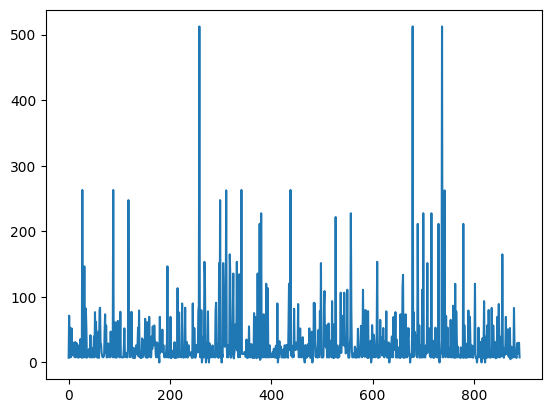

In [ ]:
titanic['fare'].plot()

In [ ]:
titanic.pivot_table('survived', ['sex', age], [fare, 'class'])

fare            (-0.001, 14.454]                     (14.454, 512.329]  \
class                      First    Second     Third             First   
sex    age                                                               
female (0, 18]               NaN  1.000000  0.714286          0.909091   
       (18, 80]              NaN  0.880000  0.444444          0.972973   
male   (0, 18]               NaN  0.000000  0.260870          0.800000   
       (18, 80]              0.0  0.098039  0.125000          0.391304   

fare                                 
class              Second     Third  
sex    age                           
female (0, 18]   1.000000  0.318182  
       (18, 80]  0.914286  0.391304  
male   (0, 18]   0.818182  0.178571  
       (18, 80]  0.030303  0.192308

### 추가 피벗 테이블 옵션

데이터프레임의 `pivot_table` 메서드의 전체 형태는 다음과 같다:


```python
# call signature as of Pandas 0.18
DataFrame.pivot_table(data, values=None, index=None, columns=None,
                      aggfunc='mean', fill_value=None, margins=False,
                      dropna=True, margins_name='All')
```

`fill_value`와 `dropna` 옵션은 누락된 데이터와 관련이 있다.
`aggfunc` 키워드는 어떤 유형의 집계를 적용할지 지정하며 디폴트는 평균(mean)이다.
GroupBy에서와 마찬가지로 집계 유형으로는 `'sum'`, `'mean'`, `'count'`, `'min'`, `'max'`이거나 혹은 ``np.sum()``, ``min()``, ``sum()`` 등의 집계를 구현하는 함수일 수 있다. 혹은 열을 위의 원하는 옵션 중 하나에 매핑하는 사전으로 지정할 수도 있다:

In [ ]:
titanic.pivot_table(index='sex', columns='class',
                    aggfunc={'survived':'sum', 'fare':'mean'})

fare                       survived             
class        First     Second      Third    First Second Third
sex                                                           
female  106.125798  21.970121  16.118810       91     70    72
male     67.226127  19.741782  12.661633       45     17    47

여기서는 `values` 키워드를 생략했는데, `aggfunc`에 대한 매핑을 지정할 때 자동으로 결정된다.

때로는 각 그룹에 따라 합계(totals)를 계산하는 것이 유용할 때가 있다.
이 작업은 `margins` 키워드를 통해 수행할 수 있다:

In [ ]:
titanic.pivot_table('survived', index='sex', columns='class', margins=True)

class,First,Second,Third,All
sex,,,,
female,0.968085,0.921053,0.500000,0.742038
male,0.368852,0.157407,0.135447,0.188908
All,0.629630,0.472826,0.242363,0.383838


성별에 관계없이 클래스별 생존율, 클래스에 관계없이 성별 생존율, 그리고 전체 생존율 38%에 대한 정보가 표시된다.


## 예제: 출생률 데이터

다른 예로 미국 질병통제센터(CDC)에서 제공하는 미국 내 출생에 대한 무료 데이터를 살펴보자. 이 데이터의 출처는 [여기](https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv)이며 파일은 [여기](https://drive.google.com/file/d/1WVGfRgoNjAo7RlzYG627_KdC85cZhdg5/view?usp=share_link)에서 다운로드할 수 있다.
(이 데이터 세트는 Andrew Gelman에 의해 상당히 광범위하게 분석되었다. [이 블로그](http://andrewgelman.com/2012/06/14/cool-ass-signal-processing-using-gaussian-processes/) 참조):

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
births = pd.read_csv('/content/drive/MyDrive/DataScience2023/chap04_pandas/datasets/births.csv')
births.head()

,year,month,day,gender,births
0,1969,1,1.0,F,4046
1,1969,1,1.0,M,4440
2,1969,1,2.0,F,4454
3,1969,1,2.0,M,4548
4,1969,1,3.0,F,4548


데이터를 살펴보면 날짜와 성별에 따라 그룹화된 출생자 수가 포함되어 있는 비교적 단순한 데이터임을 알 수 있다:

피벗 테이블을 사용하면 이 데이터를 좀 더 이해하기 시작할 수 있다. `decade` 열을 추가하고 `decade`의 함수로 남성과 여성의 출생 수를 살펴보자:

In [ ]:
births['decade'] = 10 * (births['year'] // 10)
births.pivot_table('births', index='decade', columns='gender', aggfunc='sum')

gender,F,M
decade,,
1960,1753634,1846572
1970,16263075,17121550
1980,18310351,19243452
1990,19479454,20420553
2000,18229309,19106428


매 `decade`마다 남성 출생이 여성 출생보다 많다는 것을 알 수 있다. 이 추세를 좀 더 명확하게 보기 위해 Pandas에 내장된 플로팅 도구를 사용하여 연도별 총 출생자 수를 시각화할 수 있다:

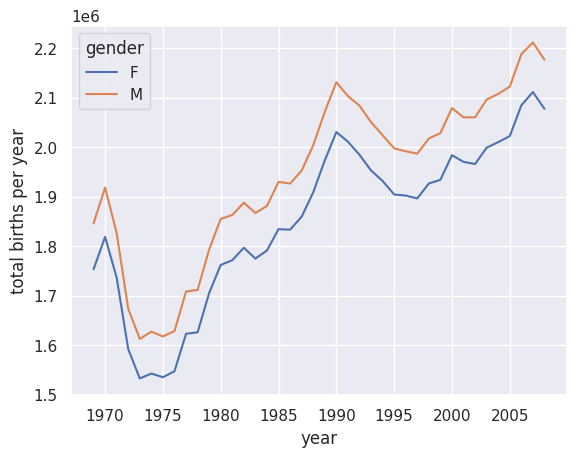

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
sns.set()  # use Seaborn styles
births.pivot_table('births', index='year', columns='gender', aggfunc='sum').plot()
plt.ylabel('total births per year');

이렇게 간단한 피벗 테이블과 `plot()` 메서드를 사용하면 성별에 따른 연간 출생 추세를 즉시 확인할 수 니다. 눈으로 보기에 지난 50년 동안 남성 출생이 여성 출생보다 약 5% 더 많은 것으로 보인다.